In [28]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import rasterio as rio

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
# ---- CONFIG ----
DATA_DIR = "content/baseline"   # folder with per-date subfolders
SHAPEFILE = "content/mines/mines_cils.shp"

TARGET_CRS = "EPSG:4326"
TARGET_RES = 10  # meters


GROUP 1 — Load & Verify Mine Boundary

In [3]:
import geopandas as gpd

mine = gpd.read_file(SHAPEFILE)
print(mine.head())
print("CRS:", mine.crs)


   area  perimeter                                           geometry
0  0.08       1.11  POLYGON ((81.40733 24.37716, 81.4073 24.37715,...
1  0.23       1.97  POLYGON ((81.15409 21.19241, 81.15406 21.19241...
2  2.24       6.89  POLYGON ((79.3912 24.00481, 79.39117 24.00481,...
3  0.16       1.63  POLYGON ((79.9191 20.10369, 79.91862 20.10367,...
4  0.11       1.47  POLYGON ((79.73162 21.66391, 79.73159 21.66391...
CRS: EPSG:4326


GROUP 2 — Load One Date (Band Stack Builder)

In [5]:
AOI = {"type":"Polygon","coordinates":[[[81.40733058102686,24.377155482500118],[81.4073007249647,24.377153096993126],[81.40727078616953,24.377154338106116],[81.40724128744056,24.377159184166736],[81.40721274389232,24.377167550551654],[81.40718565396007,24.377179291164936],[81.40716049069597,24.37719420098889],[81.40713769350863,24.377212019663958],[81.40711766049002,24.377232436035484],[81.407100741464,24.377255093586875],[81.4070872318774,24.377279596665197],[81.40635286206418,24.378863814178104],[81.40634304140194,24.378889589554426],[81.4063369959053,24.37891632192159],[81.40633482999145,24.378943549572124],[81.40633658107136,24.3789708022438],[81.40634221890377,24.378997609242287],[81.40635164611719,24.379023507570125],[81.40636469989153,24.379048049923874],[81.40638115477013,24.379070812419407],[81.40640072655361,24.379091401913517],[81.40642307720827,24.379109462793597],[81.40866483232288,24.38069366342241],[81.40869021999387,24.380709224016734],[81.40871766047363,24.38072151859773],[81.40874665594241,24.380730324119288],[81.40877668036944,24.3807354808331],[81.40880718905666,24.380736895187066],[81.40883762852042,24.38073454152207],[81.40886744653318,24.380728462538176],[81.40889610214147,24.380718768519166],[81.4089230754805,24.38070563533236],[81.40894787720535,24.38068930123775],[81.40897005736856,24.380670062565407],[81.40898921358306,24.380648268339872],[81.40900499832225,24.380624313947536],[81.40981666611327,24.37918093273858],[81.4098289167544,24.37915493152691],[81.409837192504,24.379127645803095],[81.40984133955807,24.379099582677938],[81.40984128084575,24.379071263710234],[81.40983701746082,24.37904321521311],[81.40982862864185,24.3790159584726],[81.40981627029896,24.37899000005967],[81.409800172116,24.37896582241525],[81.40978063328207,24.37894387488417],[81.40975801693043,24.37892456536414],[81.40743896226631,24.377199530562915],[81.40741450093495,24.37718367099086],[81.40738797008365,24.377170904147544],[81.40735983300175,24.37716145297099],[81.40733058102686,24.377155482500118]]]}

Define AOI Polygon (GeoJSON)

In [6]:
from shapely.geometry import shape
import geopandas as gpd


In [7]:
AOI = {
    "type": "Polygon",
    "coordinates": [[
        [81.40733058102686, 24.377155482500118],
        [81.4073007249647, 24.377153096993126],
        [81.40727078616953, 24.377154338106116],
        [81.40724128744056, 24.377159184166736],
        [81.40721274389232, 24.377167550551654],
        [81.40718565396007, 24.377179291164936],
        [81.40716049069597, 24.37719420098889],
        [81.40713769350863, 24.377212019663958],
        [81.40711766049002, 24.377232436035484],
        [81.407100741464, 24.377255093586875],
        [81.4070872318774, 24.377279596665197],
        [81.40635286206418, 24.378863814178104],
        [81.40634304140194, 24.378889589554426],
        [81.4063369959053, 24.37891632192159],
        [81.40633482999145, 24.378943549572124],
        [81.40633658107136, 24.3789708022438],
        [81.40634221890377, 24.378997609242287],
        [81.40635164611719, 24.379023507570125],
        [81.40636469989153, 24.379048049923874],
        [81.40638115477013, 24.379070812419407],
        [81.40640072655361, 24.379091401913517],
        [81.40642307720827, 24.379109462793597],
        [81.40866483232288, 24.38069366342241],
        [81.40869021999387, 24.380709224016734],
        [81.40871766047363, 24.38072151859773],
        [81.40874665594241, 24.380730324119288],
        [81.40877668036944, 24.3807354808331],
        [81.40880718905666, 24.380736895187066],
        [81.40883762852042, 24.38073454152207],
        [81.40886744653318, 24.380728462538176],
        [81.40889610214147, 24.380718768519166],
        [81.4089230754805, 24.38070563533236],
        [81.40894787720535, 24.38068930123775],
        [81.40897005736856, 24.380670062565407],
        [81.40898921358306, 24.380648268339872],
        [81.40900499832225, 24.380624313947536],
        [81.40981666611327, 24.37918093273858],
        [81.4098289167544, 24.37915493152691],
        [81.409837192504, 24.379127645803095],
        [81.40984133955807, 24.379099582677938],
        [81.40984128084575, 24.379071263710234],
        [81.40983701746082, 24.37904321521311],
        [81.40982862864185, 24.3790159584726],
        [81.40981627029896, 24.37899000005967],
        [81.409800172116, 24.37896582241525],
        [81.40978063328207, 24.37894387488417],
        [81.40975801693043, 24.37892456536414],
        [81.40743896226631, 24.377199530562915],
        [81.40741450093495, 24.37718367099086],
        [81.40738797008365, 24.377170904147544],
        [81.40735983300175, 24.37716145297099],
        [81.40733058102686, 24.377155482500118]
    ]]
}


In [8]:
mine_geom = shape(AOI)

mine = gpd.GeoDataFrame(
    {"id": [1]},
    geometry=[mine_geom],
    crs="EPSG:4326"   # AOI is lon/lat
)

mine


,id,geometry
0,1,"POLYGON ((81.40733 24.37716, 81.4073 24.37715,..."


In [9]:
assert mine.is_valid.all(), "Invalid geometry"
assert mine.geometry.type.iloc[0] == "Polygon"


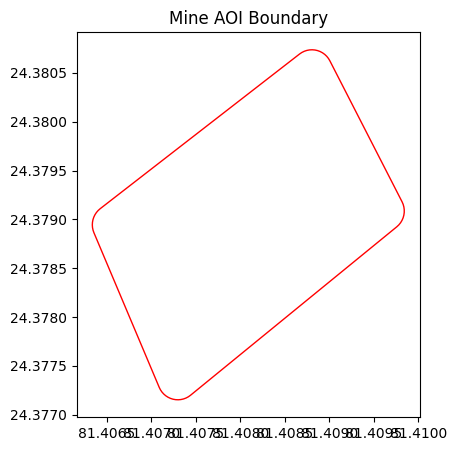

In [10]:
mine.plot(figsize=(5,5), edgecolor="red", facecolor="none")
plt.title("Mine AOI Boundary")
plt.show()


In [11]:
mine_geom = mine.geometry.values


In [ ]:
def load_and_align_band(path, ref=None):
    da = rxr.open_rasterio(path)

    if "band" in da.dims:
        da = da.isel(band=0, drop=True)

    da = da.rio.reproject(TARGET_CRS)

    if ref is not None:
        da = da.rio.reproject_match(ref)

    return da


In [29]:
def load_date_stack(date_folder):
    paths = {
        "B02": glob.glob(os.path.join(date_folder, "*_B02_*.tiff"))[0],
        "B04": glob.glob(os.path.join(date_folder, "*_B04_*.tiff"))[0],
        "B08": glob.glob(os.path.join(date_folder, "*_B08_*.tiff"))[0],
        "B11": glob.glob(os.path.join(date_folder, "*_B11_*.tiff"))[0],
        "B12": glob.glob(os.path.join(date_folder, "*_B12_*.tiff"))[0],
        "Scene_classification": glob.glob(
            os.path.join(date_folder, "*Scene_classification_map_*.tiff")
        )[0]
    }

    ref = load_and_align_band(paths["B08"])

    bands = {
        "B02": load_and_align_band(paths["B02"], ref),
        "B04": load_and_align_band(paths["B04"], ref),
        "B08": ref,
        "B11": load_and_align_band(paths["B11"], ref),
        "B12": load_and_align_band(paths["B12"], ref),
        "Scene_classification": load_scl(paths["Scene_classification"], ref),
    }

    for k in bands:
        bands[k] = bands[k].rio.clip(mine.geometry.values, mine.crs)

    return bands


GROUP 3 — Cloud Masking Using SCL

3 = cloud shadow
8 = medium cloud
9 = high cloud
10 = cirrus
11 = snow


In [34]:
def load_scl(path, ref):
    scl = rxr.open_rasterio(path)

    # drop band
    scl = scl.isel(band=0, drop=True)

    # IMPORTANT: nearest-neighbor for categorical data
    scl = scl.rio.reproject_match(
        ref,
        resampling=rio.enums.Resampling.nearest
    )

    scl = scl.astype("uint16")
    return scl


In [30]:
def apply_cloud_mask(bands):
    scl = bands["Scene_classification"]

    cloud_classes = [3, 8, 9, 10, 11]
    cloud_pixels = np.isin(scl.values, cloud_classes)

    # 🔒 Critical safeguard
    if cloud_pixels.sum() == 0:
        print("⚠️ No valid SCL cloud info — skipping mask")
        return bands

    mask = ~xr.DataArray(cloud_pixels, dims=scl.dims)

    for k in bands:
        if k != "Scene_classification":
            bands[k] = bands[k].where(mask)

    return bands


In [31]:
def sanity_check_band(da, name):
    finite = np.isfinite(da.values).sum()
    assert finite > 0, f"❌ {name} has zero valid pixels"


GROUP 4 — Baseline Feature Computation

In [32]:
def compute_features(b):
    sanity_check_band(b["B08"], "B08")
    sanity_check_band(b["B04"], "B04")

    ndvi = (b["B08"] - b["B04"]) / (b["B08"] + b["B04"])
    nbr  = (b["B08"] - b["B12"]) / (b["B08"] + b["B12"])
    bsi  = ((b["B11"] + b["B04"]) - (b["B08"] + b["B02"])) / \
           ((b["B11"] + b["B04"]) + (b["B08"] + b["B02"]))

    sanity_check_band(ndvi, "NDVI")

    return xr.Dataset({
        "NDVI": ndvi,
        "NBR": nbr,
        "BSI": bsi,
        "B11": b["B11"],
        "B12": b["B12"]
    })


GROUP 5 — Build Baseline Feature Cube (ALL DATES)

In [67]:
feature_list = []

for d in sorted(os.listdir(DATA_DIR)):
    path = os.path.join(DATA_DIR, d)
    if not os.path.isdir(path):
        continue

    try:
        date = pd.to_datetime(d, format="%d%m%y")
    except ValueError:
        print(f"⚠️ Skipping invalid folder {d}")
        continue

    bands = load_date_stack(path)
    bands = apply_cloud_mask(bands)

    feats = compute_features(bands)
    feats = feats.assign_coords(time=date)

    feature_list.append(feats)

baseline_cube = xr.concat(feature_list, dim="time")


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask
⚠️ No valid SCL cloud info — skipping mask


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


QUICK SANITY CHECK

In [68]:
baseline_cube

<xarray.Dataset> Size: 962kB
Dimensions:      (time: 28, y: 44, x: 39)
Coordinates:
  * time         (time) datetime64[ns] 224B 2019-09-01 2020-06-02 ... 2019-03-30
  * y            (y) float64 352B 24.38 24.38 24.38 24.38 ... 24.38 24.38 24.38
  * x            (x) float64 312B 81.41 81.41 81.41 81.41 ... 81.41 81.41 81.41
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan
    NBR          (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan
    BSI          (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan
    B11          (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan
    B12          (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan

In [60]:
print("NDVI finite pixels:",
      np.isfinite(baseline_cube["NDVI"].values).sum())

print("NDVI min:",
      float(baseline_cube["NDVI"].min()))

print("NDVI max:",
      float(baseline_cube["NDVI"].max()))


NDVI finite pixels: 26180
NDVI min: -0.15900154411792755
NDVI max: 0.8702141046524048


In [69]:
baseline_cube = xr.concat(feature_list, dim="time")

# 🔒 CRITICAL: enforce chronological order
baseline_cube = baseline_cube.sortby("time")
baseline_cube

<xarray.Dataset> Size: 962kB
Dimensions:      (time: 28, y: 44, x: 39)
Coordinates:
  * time         (time) datetime64[ns] 224B 2019-01-04 2019-02-13 ... 2020-12-24
  * y            (y) float64 352B 24.38 24.38 24.38 24.38 ... 24.38 24.38 24.38
  * x            (x) float64 312B 81.41 81.41 81.41 81.41 ... 81.41 81.41 81.41
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan
    NBR          (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan
    BSI          (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan
    B11          (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan
    B12          (time, y, x) float32 192kB nan nan nan nan ... nan nan nan nan

In [63]:
assert "band" not in baseline_cube.dims
assert np.isfinite(baseline_cube["NDVI"].values).any()
assert baseline_cube.time.to_index().is_monotonic_increasing

print("✔ Baseline cube validated and scientifically sound")


✔ Baseline cube validated and scientifically sound


In [64]:
print("Dates loaded:")
print(baseline_cube.time.values[:5])
print("Total timesteps:", baseline_cube.sizes["time"])


Dates loaded:
['2019-01-04T00:00:00.000000000' '2019-02-13T00:00:00.000000000'
 '2019-03-30T00:00:00.000000000' '2019-04-04T00:00:00.000000000'
 '2019-04-24T00:00:00.000000000']
Total timesteps: 28


GROUP 6 — Baseline Stability Check 

/home/manikanta/anaconda3/envs/mining/lib/python3.12/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


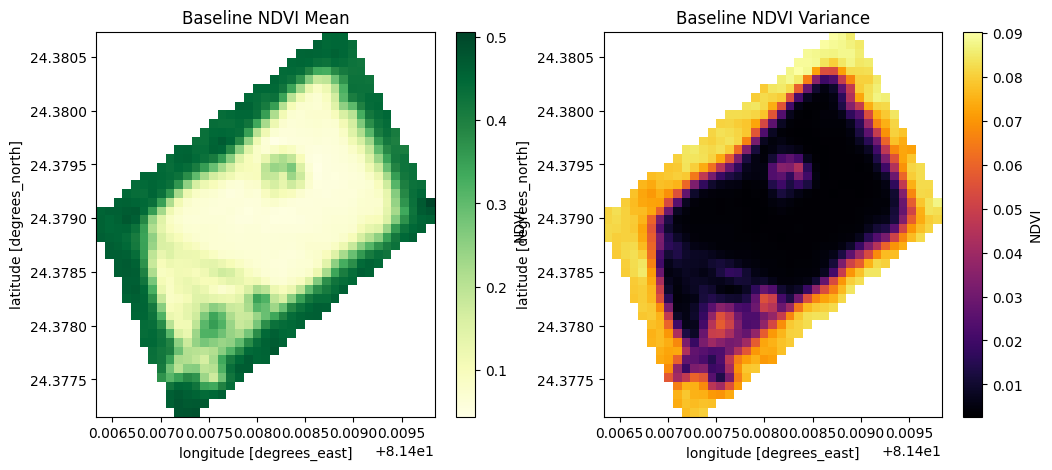

In [65]:
ndvi_mean = baseline_cube["NDVI"].mean("time")
ndvi_var  = baseline_cube["NDVI"].var("time")

fig, ax = plt.subplots(1,2, figsize=(12,5))
ndvi_mean.plot(ax=ax[0], cmap="YlGn")
ax[0].set_title("Baseline NDVI Mean")

ndvi_var.plot(ax=ax[1], cmap="inferno")
ax[1].set_title("Baseline NDVI Variance")
plt.show()


GROUP 7 — Flatten for ML (Pixel–Time Table)

In [66]:
df = baseline_cube.to_dataframe().reset_index()
df = df.dropna()

df.head()


,time,y,x,NDVI,NBR,BSI,B11,B12,spatial_ref
26,2019-01-04,24.380696,81.408717,0.386703,0.414406,-0.167495,12170.0,8061.0,0
27,2019-01-04,24.380696,81.408807,0.372682,0.411214,-0.159200,12235.0,8107.0,0
28,2019-01-04,24.380696,81.408897,0.353698,0.391269,-0.143964,12393.0,8192.0,0
64,2019-01-04,24.380615,81.408628,0.373952,0.390582,-0.146791,12517.0,8257.0,0
65,2019-01-04,24.380615,81.408717,0.367610,0.391610,-0.143253,12557.0,8303.0,0


GROUP 8 — Train BaselineModel (Unsupervised)

In [42]:
features = ["NDVI","NBR","BSI","B11","B12"]

scaler = StandardScaler()
X = scaler.fit_transform(df[features])


In [43]:
pca = PCA(n_components=3)
X_latent = pca.fit_transform(X)

print("Explained variance:", pca.explained_variance_ratio_)


Explained variance: [0.59657717 0.33623117 0.05383109]


In [44]:
BaselineModel = {
    "scaler": scaler,
    "pca": pca
}


GROUP 9 — Baseline Back-Testing (CRITICAL VALIDATION)

In [45]:
X_recon = pca.inverse_transform(X_latent)
recon_error = np.mean((X - X_recon)**2, axis=1)

df["anomaly_score"] = recon_error


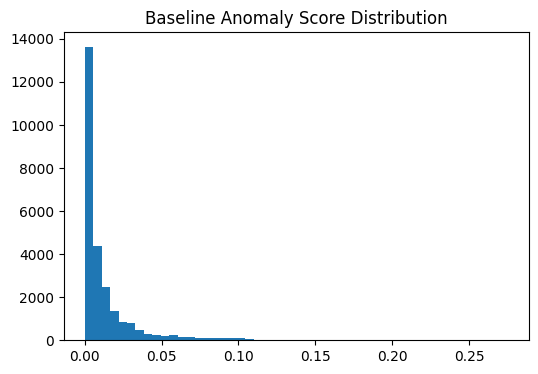

In [46]:
plt.figure(figsize=(6,4))
plt.hist(df["anomaly_score"], bins=50)
plt.title("Baseline Anomaly Score Distribution")
plt.show()


**Tests**

In [17]:
bad = []
good = []

for d in sorted(os.listdir(DATA_DIR)):
    if not os.path.isdir(os.path.join(DATA_DIR, d)):
        continue
    try:
        pd.to_datetime(d, format="%d%m%y")
        good.append(d)
    except Exception as e:
        bad.append(d)

print("✅ Valid date folders:", good)
print("❌ Invalid date folders:", bad)


✅ Valid date folders: ['010919', '020620', '020819', '030719', '040119', '040419', '060720', '080220', '090320', '090519', '101219', '130219', '130719', '140120', '160820', '161019', '180520', '180619', '191120', '200920', '201119', '220620', '220819', '240419', '241220', '251020', '280420', '300319']
❌ Invalid date folders: []


In [18]:
REQUIRED = {
    "B02": "*_B02_*.tiff",
    "B04": "*_B04_*.tiff",
    "B08": "*_B08_*.tiff",
    "B11": "*_B11_*.tiff",
    "B12": "*_B12_*.tiff",
    "SCL": "*Scene_classification_map_*.tiff",
}

report = []

for d in sorted(os.listdir(DATA_DIR)):
    path = os.path.join(DATA_DIR, d)
    if not os.path.isdir(path):
        continue

    row = {"date": d}
    for k, pattern in REQUIRED.items():
        files = glob.glob(os.path.join(path, pattern))
        row[k] = len(files)
    report.append(row)

df_files = pd.DataFrame(report)
df_files


,date,B02,B04,B08,B11,B12,SCL
0,010919,1,1,1,1,1,1
1,020620,1,1,1,1,1,1
2,020819,1,1,1,1,1,1
3,030719,1,1,1,1,1,1
4,040119,1,1,1,1,1,1
5,040419,1,1,1,1,1,1
6,060720,1,1,1,1,1,1
7,080220,1,1,1,1,1,1
8,090320,1,1,1,1,1,1
9,090519,1,1,1,1,1,1


In [19]:
sample_date = df_files.iloc[0]["date"]
sample_path = os.path.join(DATA_DIR, sample_date)

b08_path = glob.glob(os.path.join(sample_path, "*_B08_*.tiff"))[0]

da = rxr.open_rasterio(b08_path)
da


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<xarray.DataArray (band: 2, y: 44, x: 39)> Size: 7kB
[3432 values with dtype=uint16]
Coordinates:
  * band         (band) int64 16B 1 2
  * y            (y) float64 352B 24.38 24.38 24.38 24.38 ... 24.38 24.38 24.38
  * x            (x) float64 312B 81.41 81.41 81.41 81.41 ... 81.41 81.41 81.41
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

In [20]:
print("Min:", float(da.min()))
print("Max:", float(da.max()))


Min: 0.0
Max: 34537.0


In [21]:
da = rxr.open_rasterio(b08_path)

da_clip = da.rio.clip(
    mine.geometry.values,
    mine.crs,
    drop=True
)

da_clip


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/home/manikanta/anaconda3/envs/mining/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:258: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<xarray.DataArray (band: 2, y: 44, x: 39)> Size: 7kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(2, 44, 39), dtype=uint16)
Coordinates:
  * band         (band) int64 16B 1 2
  * y            (y) float64 352B 24.38 24.38 24.38 24.38 ... 24.38 24.38 24.38
  * x            (x) float64 312B 81.41 81.41 81.41 81.41 ... 81.41 81.41 81.41
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

In [22]:
print("Clipped shape:", da_clip.shape)
print("Finite pixels:", np.isfinite(da_clip.values).sum())


Clipped shape: (2, 44, 39)
Finite pixels: 3432


In [23]:
print("Raster CRS:", da.rio.crs)
print("AOI CRS:", mine.crs)


Raster CRS: EPSG:4326
AOI CRS: EPSG:4326


In [24]:
scl_path = glob.glob(os.path.join(sample_path, "*Scene_classification_map_*.tiff"))[0]
scl = rxr.open_rasterio(scl_path)
scl = scl.isel(band=0, drop=True)
scl = scl.rio.reproject(TARGET_CRS)

scl_clip = scl.rio.clip(mine.geometry.values, mine.crs)


In [25]:
unique, counts = np.unique(scl_clip.values, return_counts=True)
dict(zip(unique, counts))


{np.uint16(0): np.int64(574),
 np.uint16(65534): np.int64(361),
 np.uint16(65535): np.int64(781)}

In [26]:
b08 = rxr.open_rasterio(
    glob.glob(os.path.join(sample_path, "*_B08_*.tiff"))[0]
).isel(band=0, drop=True)

b04 = rxr.open_rasterio(
    glob.glob(os.path.join(sample_path, "*_B04_*.tiff"))[0]
).isel(band=0, drop=True)

b08 = b08.rio.reproject(TARGET_CRS)
b04 = b04.rio.reproject_match(b08)

b08 = b08.rio.clip(mine.geometry.values, mine.crs)
b04 = b04.rio.clip(mine.geometry.values, mine.crs)

ndvi = (b08 - b04) / (b08 + b04)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Finite NDVI pixels: 1716


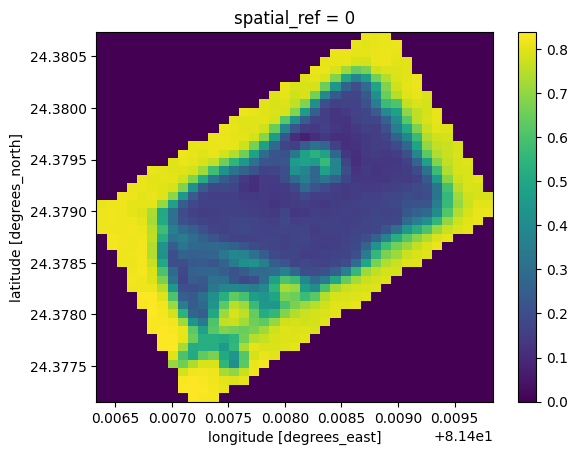

In [27]:
print("Finite NDVI pixels:", np.isfinite(ndvi.values).sum())
ndvi.plot()
plt.show()


In [47]:
bands = load_date_stack(sample_path)
bands = apply_cloud_mask(bands)

ndvi = (bands["B08"] - bands["B04"]) / (bands["B08"] + bands["B04"])
print("Finite NDVI after mask:", np.isfinite(ndvi.values).sum())


⚠️ No valid SCL cloud info — skipping mask
Finite NDVI after mask: 935


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


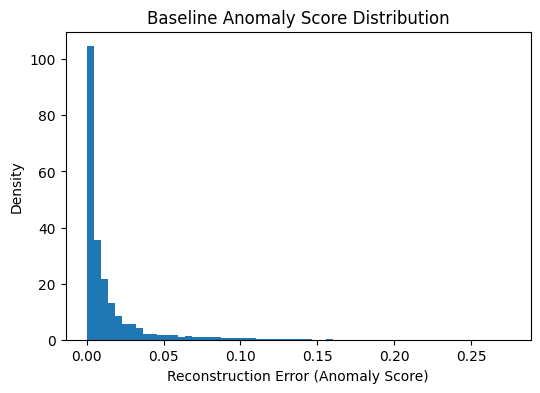

In [48]:
plt.figure(figsize=(6,4))
plt.hist(df["anomaly_score"], bins=60, density=True)
plt.xlabel("Reconstruction Error (Anomaly Score)")
plt.ylabel("Density")
plt.title("Baseline Anomaly Score Distribution")
plt.show()


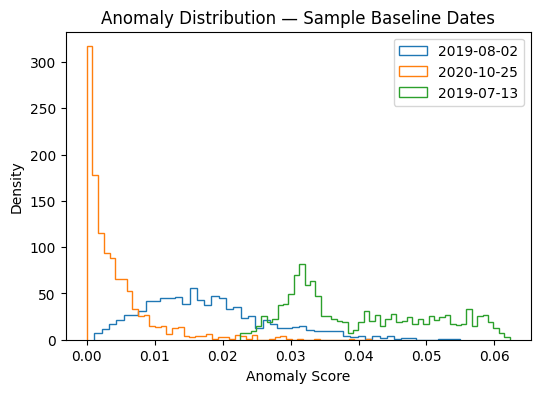

In [49]:
sample_dates = df["time"].drop_duplicates().sample(3, random_state=42)

plt.figure(figsize=(6,4))
for t in sample_dates:
    subset = df[df["time"] == t]
    plt.hist(
        subset["anomaly_score"],
        bins=50,
        density=True,
        histtype="step",
        label=str(t.date())
    )

plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.title("Anomaly Distribution — Sample Baseline Dates")
plt.legend()
plt.show()


Visualizing date: 2019-01-04 00:00:00


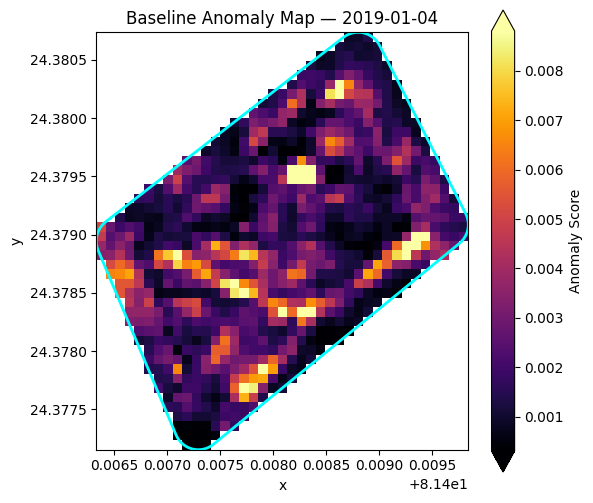

In [51]:
date0 = df["time"].iloc[0]
print("Visualizing date:", date0)

anom_map = (
    df[df["time"] == date0]
    .set_index(["y","x"])["anomaly_score"]
    .to_xarray()
)

fig, ax = plt.subplots(figsize=(6,6))

anom_map.plot(
    ax=ax,
    cmap="inferno",
    robust=True,
    cbar_kwargs={"label": "Anomaly Score"}
)

mine.boundary.plot(ax=ax, color="cyan", linewidth=2)

ax.set_title(f"Baseline Anomaly Map — {date0.date()}")
plt.show()



/home/manikanta/anaconda3/envs/mining/lib/python3.12/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


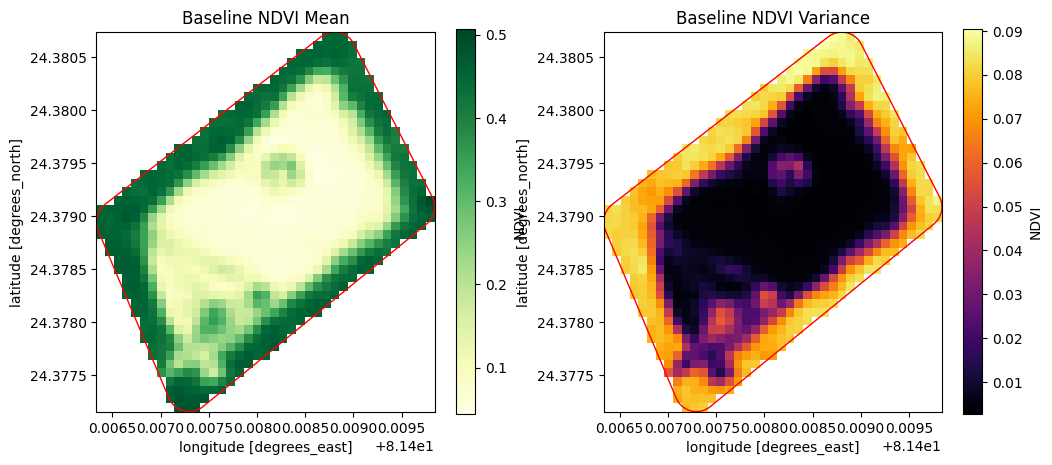

In [52]:
ndvi_mean = baseline_cube["NDVI"].mean("time")
ndvi_var  = baseline_cube["NDVI"].var("time")

fig, ax = plt.subplots(1,2, figsize=(12,5))

ndvi_mean.plot(ax=ax[0], cmap="YlGn")
mine.boundary.plot(ax=ax[0], color="red", linewidth=1)
ax[0].set_title("Baseline NDVI Mean")

ndvi_var.plot(ax=ax[1], cmap="inferno")
mine.boundary.plot(ax=ax[1], color="red", linewidth=1)
ax[1].set_title("Baseline NDVI Variance")

plt.show()


In [53]:
pixels = df[["y","x"]].drop_duplicates().sample(3, random_state=1)
pixels


,y,x
736,24.379230,81.409437
222,24.380289,81.408807
1375,24.377845,81.407279


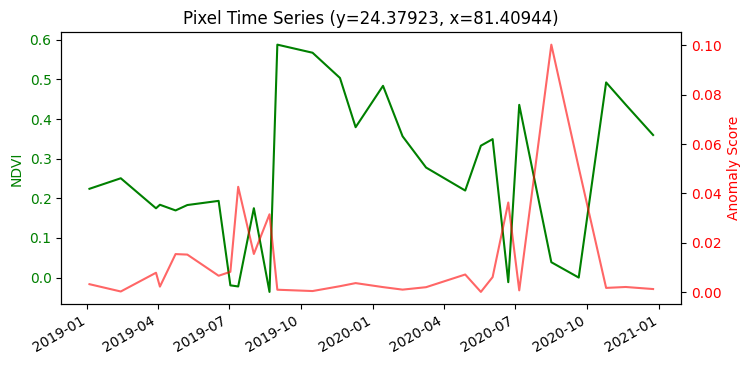

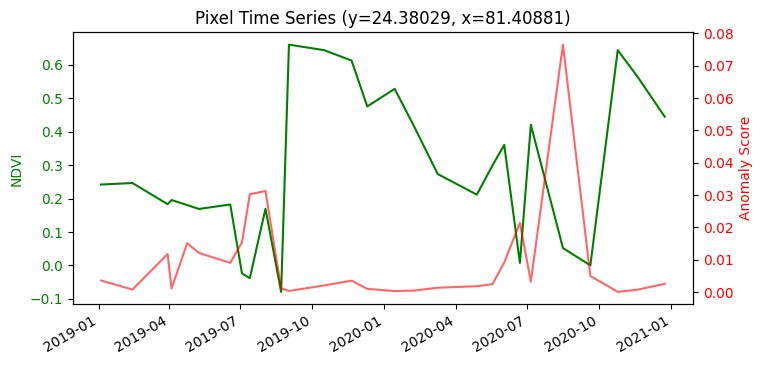

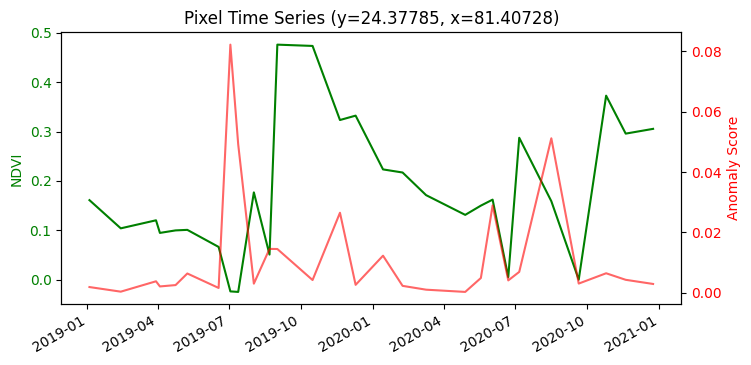

In [54]:
for _, row in pixels.iterrows():
    y, x = row["y"], row["x"]

    pix = df[(df["y"] == y) & (df["x"] == x)].sort_values("time")

    fig, ax1 = plt.subplots(figsize=(8,4))

    ax1.plot(pix["time"], pix["NDVI"], color="green", label="NDVI")
    ax1.set_ylabel("NDVI", color="green")
    ax1.tick_params(axis="y", labelcolor="green")

    ax2 = ax1.twinx()
    ax2.plot(pix["time"], pix["anomaly_score"], color="red", alpha=0.6, label="Anomaly")
    ax2.set_ylabel("Anomaly Score", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    ax1.set_title(f"Pixel Time Series (y={y:.5f}, x={x:.5f})")
    fig.autofmt_xdate()
    plt.show()
